# Práctica 2

Procesamiento de Lenguaje Natural
Facultad de Ingeniería, UNAM

González Flores Andrés

## Instrucciones

A partir del corpus proporcionado ("corpusML.txt") realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

Síganse los siguientes pasos:

1. Limpiar los textos y aplicar stemming a las palabras.
2. Insertar símbolos de inicio y final de cadena.
3. Obtener los bigramas que aparecen en el texto (indexar numéricamente).
4. Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).
5. Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuornal (probabilidad Softmax).
6. Evaluar el modelo (con Entropía).
7. Calcular la proabilidad de las siguientes oraciones:
    - Nos bañamos con agua caliente
    - El animalito le olía la cabeza
    - Pascuala ordeñaba las vacas

## Desarrollo

In [1]:
# Importar módulos
import re
from nltk import SnowballStemmer
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
# Definición de constantes
stemmer_esp = SnowballStemmer('spanish')
CORPUS_PATH = './Data/corpusML.txt'
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<unk>'

### Paso 1

Limpiar los textos y aplicar stemming a las palabras.

In [3]:
with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    corpus = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', linea.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for linea in f
    ]
    for docs in corpus[:5]:
        print(docs) # Muestro 5 ejemplos

['comenc', 'a', 'trabaj', 'y', 'me', 'peg', 'me', 'maltrat', 'con', 'chicot']
['mis', 'patron', 'me', 'peg', 'porqu', 'no', 'me', 'quer', 'apur', 'porqu', 'era', 'floj']
['por', 'eso', 'me', 'hab', 'peg']
['cuand', 'me', 'peg', 'ya', 'entonc', 'me', 'quit']
['pues', 'entonc', 'no', 'quis', 'trabaj']


Divido el corpus en entrenamiento y evaluación

In [4]:
train_corpus, eval_corpus = train_test_split(corpus, test_size=0.3)

print(f'\nTamaño del corpus de entrenamiento: {len(train_corpus)}')
print('Ejemplos:')
for docs in train_corpus[:5]:
        print(docs) # Muestro 5 ejemplos

print(f'\nTamaño del corpus de evaluación: {len(eval_corpus)}')
print('Ejemplos:')
for docs in eval_corpus[:5]:
        print(' ', docs) # Muestro 5 ejemplos


Tamaño del corpus de entrenamiento: 751
Ejemplos:
['per', 'un', 'pobr', 'pues', 'nad']
['si', 'lo', 'fuim', 'a', 'tir', 'o', 'nos', 'lo', 'fuim', 'a', 'com']
['lo', 'emprest', 'nomas', 'lo', 'mas', 'necesari', 'par', 'uno']
['pues', 'no', 'se', 'si', 'ser']
['pues', 'cuand', 'lo', 'gast', 'estab', 'un', 'burrit', 'chiquit']

Tamaño del corpus de evaluación: 323
Ejemplos:
  ['me', 'hab', 'habl', 'mi', 'señor']
  ['por', 'que', 'usted', 'lo', 'hic']
  ['nomas', 'quem', 'las', 'hierb', 'y', 'tod', 'los', 'olot']
  ['he', 'termin', 'tod', 'mis', 'papel']
  ['prefer', 'sal', 'de', 'mi', 'cas']


Muestro la curva de zipf

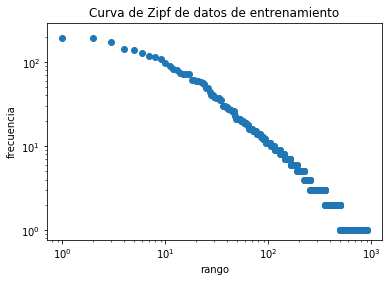

In [5]:
frec = sum([Counter(doc) for doc in train_corpus], Counter())

plt.plot(sorted(frec.values(), reverse=True), 'o')
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.title('Curva de Zipf de datos de entrenamiento')
plt.show()

Sustituyo los hapax por el identificador <unk\>

In [7]:
train_corpus_unk = [
    [
        # Si la frecuencia de la palabra es 1, se sustituye por UNK
        (UNK if frec[w] == 1 else w)
        for w in doc
    ] 
    for doc in train_corpus 
]

print('Ejemplos:')
for docs in train_corpus_unk[:5]:
        print(docs) # Muestro 5 ejemplos

Ejemplos:
['per', 'un', 'pobr', 'pues', 'nad']
['si', 'lo', 'fuim', 'a', 'tir', 'o', 'nos', 'lo', 'fuim', 'a', 'com']
['lo', '<unk>', 'nomas', 'lo', 'mas', '<unk>', 'par', 'uno']
['pues', 'no', 'se', 'si', 'ser']
['pues', 'cuand', 'lo', 'gast', 'estab', 'un', 'burrit', 'chiquit']


### Paso 2

Insertar símbolos de inicio y final de cadena.

In [10]:
train_corpus_unk = list(map(lambda doc: [BOS, *doc, EOS], train_corpus_unk))
for doc in train_corpus_unk[:5]:
    print(doc)

['<BOS>', 'per', 'un', 'pobr', 'pues', 'nad', '<EOS>']
['<BOS>', 'si', 'lo', 'fuim', 'a', 'tir', 'o', 'nos', 'lo', 'fuim', 'a', 'com', '<EOS>']
['<BOS>', 'lo', '<unk>', 'nomas', 'lo', 'mas', '<unk>', 'par', 'uno', '<EOS>']
['<BOS>', 'pues', 'no', 'se', 'si', 'ser', '<EOS>']
['<BOS>', 'pues', 'cuand', 'lo', 'gast', 'estab', 'un', 'burrit', 'chiquit', '<EOS>']


### Paso 3

Obtener los bigramas que aparecen en el texto (indexar numéricamente).

In [13]:
# Indexo numéricamente los stems
vocab = defaultdict() 
# El método default_factory sirve para asignar un nuevo valor por defecto
# en caso de no encontrar el indice dado
vocab.default_factory = lambda: len(vocab)

# Indexo numéricamente las palabras en los documentos
corpus_ids = [[vocab[w] for w in doc] for doc in train_corpus_unk]

print('Ejemplos de palabras en el vocabulario')
for palabra, i in list(vocab.items())[:10]:
    print(f'  {palabra} : {i}')

print('\nEjemplos de oraciones indexadas numéricamente')
for doc in corpus_ids[:6]:
    print(' ', doc)

Ejemplos de palabras en el vocabulario
  <BOS> : 0
  per : 1
  un : 2
  pobr : 3
  pues : 4
  nad : 5
  <EOS> : 6
  si : 7
  lo : 8
  fuim : 9

Ejemplos de oraciones indexadas numéricamente
  [0, 1, 2, 3, 4, 5, 6]
  [0, 7, 8, 9, 10, 11, 12, 13, 8, 9, 10, 14, 6]
  [0, 8, 15, 16, 8, 17, 15, 18, 19, 6]
  [0, 4, 20, 21, 7, 22, 6]
  [0, 4, 23, 8, 24, 25, 2, 26, 27, 6]
  [0, 14, 28, 29, 30, 31, 29, 32, 4, 4, 33, 34, 6]


```doc[:-1]``` toma todos las cadenas de un documento (frase) excepto la última

```doc[1:]``` toma todos las cadenas de un documento (frase) excepto la primera

Con zip, uno una cadena de la primer lista con una de la segunda en tuplas (bigramas)

In [14]:
bigramas = [bi for doc in train_corpus_unk for bi in zip(doc[:-1], doc[1:])]

bigramas[:20] # Ejemplos con cadenas

[('<BOS>', 'per'),
 ('per', 'un'),
 ('un', 'pobr'),
 ('pobr', 'pues'),
 ('pues', 'nad'),
 ('nad', '<EOS>'),
 ('<BOS>', 'si'),
 ('si', 'lo'),
 ('lo', 'fuim'),
 ('fuim', 'a'),
 ('a', 'tir'),
 ('tir', 'o'),
 ('o', 'nos'),
 ('nos', 'lo'),
 ('lo', 'fuim'),
 ('fuim', 'a'),
 ('a', 'com'),
 ('com', '<EOS>'),
 ('<BOS>', 'lo'),
 ('lo', '<unk>')]

In [15]:
bigramas_ids = [bi for doc in corpus_ids for bi in zip(doc[:-1], doc[1:])]
bigramas_ids[:20] # Ejemplos de bigramas indexados numéricamente

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (0, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 8),
 (8, 9),
 (9, 10),
 (10, 14),
 (14, 6),
 (0, 8),
 (8, 15)]

### Paso 4

Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).